In [1]:
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
import scipy.sparse as sp
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
import torch
from torch.autograd import Variable

In [2]:
def loadMovieLens(path='./ml-1m'):
    # Get movie titles
    movies={}
    for line in open(path+'/movies.dat'):
        (id,title)=line.split('::')[0:2]
        movies[id]=title
    # Load data
    prefs={}
    for line in open(path+'/ratings.dat'):
        (user,movieid,rating,ts)=line.split('::')
        prefs.setdefault(user,{})
        prefs[user][movies[movieid]]=float(rating)
    return prefs, movies

In [3]:
dico, movies = loadMovieLens()

In [4]:
def inverse_dico(dico):
    d = dict()
    for k,v in dico.items():
        d[v]=k
    return d

In [5]:
movies_inv = inverse_dico(movies)

In [6]:
def create_sparse(dico, movies):
    user_ratings_mean = []
    
    nb_u = max([ int(k) for k in dico.keys()])+1
    nb_f = max([ int(k) for k in movies.values()])+1
    
    #train
    mat_mean_train = sp.dok_matrix((nb_u , nb_f))
    mat_ori_train = sp.dok_matrix((nb_u , nb_f))
    
    for id_c, m in dico.items():
        moy=np.mean((list(m.values())))
        for f, note in m.items():
            mat_mean_train[int(id_c)-1,int(movies_inv[f])] = note-moy
            mat_ori_train[int(id_c)-1,int(movies_inv[f])] = note
        user_ratings_mean.append(moy)             
        
    return mat_mean_train, mat_ori_train, np.array(user_ratings_mean)

In [7]:
mat_train, mat_ori_train, user_ratings_mean = create_sparse(dico, movies_inv)

In [8]:
nb_u = max([ int(k) for k in dico.keys()])+1
nb_f = max([ int(k) for k in movies.keys()])+1
nb_user = nb_u -int( nb_u *0.10)
nb_mov = nb_f -int( nb_f *0.10)

In [9]:
mat_ori = mat_ori_train.copy()
mat_test = sp.dok_matrix((nb_u , nb_f))
mat_test[nb_user:, nb_mov:] = mat_train[nb_user:, nb_mov:]
mat_ori_test = sp.dok_matrix((nb_u , nb_f ))
mat_ori_test[nb_user:, nb_mov:] = mat_ori_train[nb_user:, nb_mov:]

mat_train[nb_user: , nb_mov:]=0
mat_ori_train[nb_user:, nb_mov:]=0

In [10]:
def score_quad(mat_ori,pred):
    cout = 0
    n = 0
    for i,j in mat_ori.keys():
        n += 1
        cout += abs(mat_ori[i,j]-pred[i][j])**2
    return cout/n

SVD

In [92]:
res_cout_train = []
res_cout_test = []
for n in [2, 5, 10, 20, 40, 60, 80, 100]:
    svd = TruncatedSVD(n_components=n, random_state=0)
    svd.fit(mat_train)
    U, sigma, Vt = svd.components_, svd.explained_variance_ratio_, svd.singular_values_
    sigma = np.diag(sigma)
    all_user_predicted_ratings = np.dot(np.dot(U.T, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
    res_cout_train.append(score_quad(mat_ori_train, all_user_predicted_ratings))
    res_cout_test.append(score_quad(mat_ori_test, all_user_predicted_ratings))

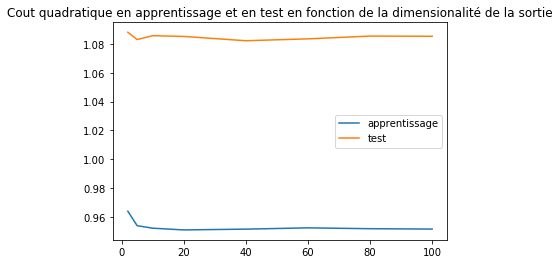

In [93]:
plt.plot([2, 5, 10, 20, 40, 60, 80, 100], res_cout_train, label="apprentissage")
plt.plot([2, 5, 10, 20, 40, 60, 80, 100], res_cout_test, label="test")
plt.title("Cout quadratique en apprentissage et en test en fonction de la dimensionalité de la sortie")
plt.legend()
plt.show()

In [98]:
tab= np.array([res_cout_train, res_cout_test]).T
pd.DataFrame(tab, columns=["MSE en apprentissage", "MSE en test"], index=[2, 5, 10, 20, 40, 60, 80, 100])

,MSE en apprentissage,MSE en test
2,0.963915,1.088177
5,0.953888,1.083100
10,0.952139,1.085789
20,0.950948,1.085271
40,0.951494,1.082277
60,0.952377,1.083588
80,0.951793,1.085511
100,0.951532,1.085381


On observe que l'erreur en test est la plus faible pour n_components = 5 donc on décide de réaliser nos recommandations avec ce paramètre

In [95]:
svd = TruncatedSVD(n_components=5, random_state=0)
svd.fit(mat_train)
U, sigma, Vt = svd.components_, svd.explained_variance_ratio_, svd.singular_values_
sigma = np.diag(sigma)
all_user_predicted_ratings = np.dot(np.dot(U.T, sigma), Vt) + user_ratings_mean.reshape(-1, 1)

In [37]:
def recommend_movies(pred, userID, movies, mat_ori, num_rec=5):
    #trie les notes -> récupère les indices
    sort_id_pred = np.argsort(-pred[userID-1])
    
    #récupère les films déjà vu par l'utilisateur
    user_data = mat_ori[userID-1]    
    res = []    
    i = 0
    for p in sort_id_pred:
        if(mat_ori[userID-1][(0, p)]==0):
            res.append([movies[str(p+1)], pred[userID-1][p]])
            i +=1
        if(i==num_rec):
            break
    return res  

In [97]:
r = recommend_movies(all_user_predicted_ratings, 5, movies, mat_ori)
pd.DataFrame(r, columns=["film", "note estimée"])

,film,note estimée
0,Little Women (1994),4.749726
1,Brazil (1985),4.696947
2,"Princess Bride, The (1987)",4.662173
3,Taxi Driver (1976),4.334350
4,Wings of Desire (Der Himmel über Berlin) (1987),4.289879


NMF

In [32]:
nmf_res_cout_train = []
nmf_res_cout_test = []
for n in [2, 5, 10, 20, 40, 60, 80, 100]:
    nmf = NMF(n_components=n, init='random', solver = 'mu', max_iter=700, tol=0.0001 )
    W = nmf.fit_transform(mat_ori_train) 
    H = nmf.components_
    nmf_pred= np.dot(W,H)
    nmf_res_cout_train.append(score_quad(mat_ori_train, nmf_pred))
    nmf_res_cout_test.append(score_quad(mat_ori_test, nmf_pred))

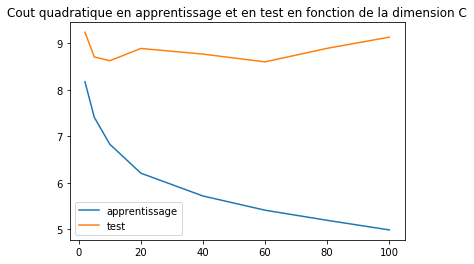

In [33]:
plt.plot([2, 5, 10, 20, 40, 60, 80, 100], nmf_res_cout_train, label="apprentissage")
plt.plot([2, 5, 10, 20, 40, 60, 80, 100], nmf_res_cout_test, label="test")
plt.title("Cout quadratique en apprentissage et en test en fonction de la dimension C")
plt.legend()
plt.show()

In [34]:
tab= np.array([nmf_res_cout_train, nmf_res_cout_test]).T
pd.DataFrame(tab, columns=["cout MSE en apprentissage", "Cout MSE en test"], index=[2, 5, 10, 20, 40, 60, 80, 100])

,cout MSE en apprentissage,Cout MSE en test
2,8.169461,9.233693
5,7.407550,8.704080
10,6.828230,8.621561
20,6.205860,8.885478
40,5.715776,8.764013
60,5.410702,8.597508
80,5.193152,8.888490
100,4.987090,9.128422


In [35]:
nmf = NMF(n_components=5, init='random', max_iter=1000, tol=0.0001)
W = nmf.fit_transform(mat_ori_train) 
H = nmf.components_
nmf_pred= np.dot(W,H)

In [38]:
r = recommend_movies(nmf_pred, 5, movies, mat_ori)
pd.DataFrame(r, columns=["film", "note estimée"])

,film,note estimée
0,"Scout, The (1994)",3.069851
1,Mass Appeal (1984),2.843230
2,Don Juan DeMarco (1995),2.337794
3,Onegin (1999),2.299196
4,Price of Glory (2000),2.223488


On remarque que les résultats sont beaucoup moins bon qu'avec SVD car NMF prend les 0 comme des valeurs au lieu de les prendre comme des valeurs manquantes.

Descente de gradient stochastique

In [11]:
class FactMatrice(torch.autograd.Function):
    @staticmethod 
    def forward(ctx, user_factors, film_factors):
        ctx.input=(user_factors, film_factors)
        return (user_factors@film_factors)

    @staticmethod
    def backward(ctx, delta):
        x,y =ctx.input
        return x , y

In [12]:
user_factors = torch.nn.Parameter(torch.randn((nb_u, 5), requires_grad=True))
film_factors = torch.nn.Parameter(torch.randn( (5, nb_f), requires_grad=True))
model = FactMatrice.apply

loss_fonc = torch.nn.MSELoss()
optimizer = torch.optim.SGD([user_factors,film_factors], lr=1e-4)

In [13]:
mat = np.array(list(mat_ori_train.keys()))
np.random.shuffle(mat)

mat_test = np.array(list(mat_ori_test.keys()))

In [38]:
i = 0
nb_batch=1000
max_iter = 1500
l_loss = []

while(i+nb_batch<len(mat) and i<max_iter):
    i += 1
    notes = []
    preds = []
    #Prédire et calculer la loss
    pred = model(user_factors, film_factors)
    
    for ligne, col in mat[i:i+nb_batch]:
        #changer les données en variable
        notes.append(mat_ori_train[ligne, col])
        ligne = Variable(torch.LongTensor([np.long(ligne)]))
        col = Variable(torch.LongTensor([np.long(col)]))        
        preds.append(pred[ligne,col])
        
    notes = Variable(torch.FloatTensor(notes))    
    preds = Variable (torch.FloatTensor(preds), requires_grad=True)
    loss = loss_fonc(preds, notes)
    l_loss.append(loss.item())

    optimizer.zero_grad()
    #backpropagation
    loss.backward()

    #m.a.j params
    optimizer.step()
    
    notes_test = []
    pred_test = []
    #test
    for ligne, col in mat_test:
        notes_test.append(mat_ori_test[ligne, col])
        ligne = Variable(torch.LongTensor([np.long(ligne)]))
        col = Variable(torch.LongTensor([np.long(col)]))        
        pred_test.append(pred[ligne,col])
        
    notes_test = Variable(torch.FloatTensor(notes_test))    
    pred_test = Variable (torch.FloatTensor(pred_test), requires_grad=True)
    l_test = loss_fonc(pred_test, notes_test)
    l_loss_test.append(l_test.item())

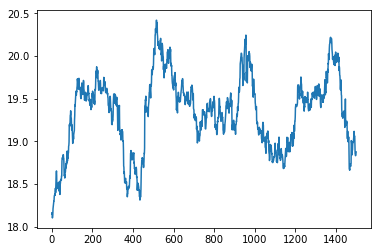

In [39]:
plt.plot(range(max_iter),l_loss_train, label="apprentissage")
plt.plot(range(max_iter), l_loss_test, label="test")
plt.title("Cout en apprentissage et en test d'une descente de gradient en fonction des itérations")
plt.legend()
plt.show()

In [17]:
class BiasedMatrixFact(torch.autograd.Function):
    @staticmethod
    def forward(ctx, user, film, biais_user, biais_film):
        ctx.input = (user, biais_user, film, biais_film)
        """print("bu", biais_user.size())
        print("bf", biais_film.size())
        print("user", user.size())
        print("film", film.size())"""
        return (user@film)+biais_user.view(-1,1)+biais_film
    
    @staticmethod
    def backward(ctx, delta):
        x, bu, y, bf = ctx.input
        bu = torch.ones(len(bu))
        bf = torch.ones(len(bf))
        return x@delta, y@delta, bu@delta, bf@delta

In [27]:
n_comp=3
user_factors = torch.nn.Parameter(torch.randn((nb_u, n_comp), requires_grad=True))
film_factors = torch.nn.Parameter(torch.randn((n_comp, nb_f), requires_grad=True))
biais_user = torch.nn.Parameter(torch.randn(nb_u, requires_grad=True))
biais_film = torch.nn.Parameter(torch.randn(nb_f, requires_grad=True))
model = BiasedMatrixFact.apply

loss_fonc = torch.nn.MSELoss()
optimizer = torch.optim.SGD([user_factors,film_factors, biais_user, biais_film], lr=1e-3)

In [30]:
i = 0
nb_batch=1000
max_iter = 5
l_loss_train = []
l_loss_test = []
j=0
res_loss_train = []
res_loss_test = []

while(j<max_iter):
    if(i+nb_batch>=len(mat)):
        print("j=",j)
        i=0
        j+=1
        res_loss_train.append(np.mean(l_loss_train))
        l_loss_train = []
        res_loss_test.append(np.mean(l_loss_test))
        l_loss_test = []
        
    notes = []
    preds = []
    #Prédire et calculer la loss
    pred = model(user_factors, film_factors, biais_user, biais_film)
    
    for ligne, col in mat[i:i+nb_batch]:
        #changer les données en variable
        notes.append(mat_ori_train[ligne, col])
        ligne = Variable(torch.LongTensor([np.long(ligne)]))
        col = Variable(torch.LongTensor([np.long(col)]))        
        preds.append(pred[ligne,col])
        
    notes = Variable(torch.FloatTensor(notes))    
    preds = Variable (torch.FloatTensor(preds), requires_grad=True)
    loss = loss_fonc(preds, notes)
    l_loss_train.append(loss.item())

    optimizer.zero_grad()
    #backpropagation
    loss.backward()

    #m.a.j params
    optimizer.step()
    
    notes_test = []
    pred_test = []
    #test
    for ligne, col in mat_test:
        notes_test.append(mat_ori_test[ligne, col])
        ligne = Variable(torch.LongTensor([np.long(ligne)]))
        col = Variable(torch.LongTensor([np.long(col)]))        
        pred_test.append(pred[ligne,col])
        
    notes_test = Variable(torch.FloatTensor(notes_test))    
    pred_test = Variable (torch.FloatTensor(pred_test), requires_grad=True)
    l_test = loss_fonc(pred_test, notes_test)
    l_loss_test.append(l_test.item())
    
    i += nb_batch

j= 0
j= 1
j= 2
j= 3
j= 4


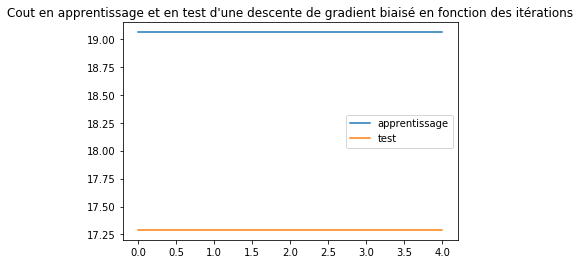

In [31]:
plt.plot(range(max_iter),res_loss_train, label="apprentissage")
plt.plot(range(max_iter), res_loss_test, label="test")
plt.title("Cout en apprentissage et en test d'une descente de gradient biaisé en fonction des itérations")
plt.legend()
plt.show()